# Практика 2-3 #

## Реальные данные (E.coli первый датасет) ##

### Задание 0 ###

На всякий случай выпишу команды, которые я использовала.

Сначала построим индекс по референсному геному с помощью bowtie2:

! bowtie2-build /home/kolchina/ngs_2_data/Illumina/E.coli/MG1655-K12.fasta /home/kolchina/ngs_2_data/real.btindex

Теперь сделаем выравнивание наших парных ридов по референсному геному:

! bowtie2 -p 2 -x /home/kolchina/ngs_2_data/real.btindex -1 /home/kolchina/ngs_2_data/Illumina/E.coli/100x.1.fastq -2 /home/kolchina/ngs_2_data/Illumina/E.coli/100x.2.fastq -S real.sam

In [4]:
! samtools flagstat real.sam

5000000 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
4974567 + 0 mapped (99.49% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4957474 + 0 properly paired (99.15% : N/A)
4959050 + 0 with itself and mate mapped
15517 + 0 singletons (0.31% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


Процент приложившихся ридов: 99.49%

### Задание 1 ###

In [25]:
import pysam
import matplotlib.pyplot as plt
%matplotlib inline

Конвертируем в bam формат (с ним проще работать):

In [62]:
! samtools view -S -b real.sam > real.bam

Посортим:

In [63]:
! samtools sort real.bam -o real.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...


Проиндексируем:

In [64]:
! samtools index real.bam out.index

Наконец откроем файлик:

In [36]:
samfile = pysam.AlignmentFile("real.bam", "r", index_filename="out.index")

Посмотрим на начало файлика, чтобы убедиться, что все ОК:

In [66]:
! head real.sam

@HD	VN:1.0	SO:unsorted
@SQ	SN:gi|49175990|ref|NC_000913.2|	LN:4639675
@PG	ID:bowtie2	PN:bowtie2	VN:2.3.5.1	CL:"/usr/bin/bowtie2-align-s --wrapper basic-0 -p 2 -x /home/kolchina/ngs_2_data/real.btindex -S real.sam -1 /home/kolchina/ngs_2_data/Illumina/E.coli/100x.1.fastq -2 /home/kolchina/ngs_2_data/Illumina/E.coli/100x.2.fastq"
EAS20_8_6_88_1430_1004	83	gi|49175990|ref|NC_000913.2|	2497537	24	100M	=	2497413	-224	AAAACAACAATAAAAACAAAGAAGAAACCCCCCCCACCACAAAGAATCCATCCCATCCTGTGAACCCATTGTGGGAGAAAGGGGTCGTGACCGGAACGCT	#######################################################################G4HHHHHHHHHHEHHHHHHHHHGHHHHGG	AS:i:-40	XN:i:0	XM:i:20	XO:i:0	XG:i:0	NM:i:20	MD:Z:3T2T2T9T2T3G3A2G3A0C2G3T2A0T3A0T0G1T0G4T36	YS:i:0	YT:Z:CP
EAS20_8_6_88_1430_1004	163	gi|49175990|ref|NC_000913.2|	2497413	24	100M	=	2497537	224	GCCGATGCGGTGGCGATTACTAATACCGATCATGTGCTGGCCTATGTTGGCGTGGGTGAACATAACTATCAGAATGGCGATGACTTCATTAGCCCGACTA	HHHEHBHCHFGHDGGFHHHHHHHGHHHFHEFHHHDHHHEGDIHHHHHHHHCHGFHH?H=FFFHHBAHFHG@D=EBEDF@GD?9;GF

In [67]:
# arr = samfile.count_coverage("gi|49175990|ref|NC_000913.2|")

Соберем массив, где на i-ой позиции стоит число ридов, приложившихся к i-ому нуклеотиду:

In [37]:
arr1 = []
for pileupcolumn in samfile.pileup():
    arr1.append(pileupcolumn.n)

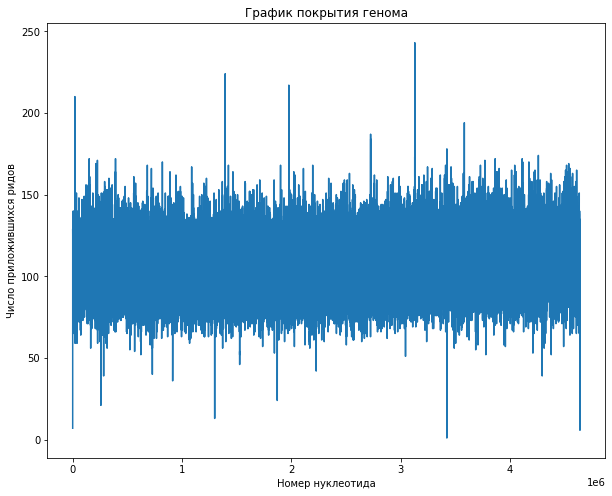

In [38]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()
plt.title("График покрытия генома")
ax.set_xlabel("Номер нуклеотида")
ax.set_ylabel("Число приложившихся ридов")
plt.plot(arr1)
plt.show()

Разобьем нуклеотиды на бакеты по 1000 штук для удобства визуализации:

In [39]:
arr2 = []
start = 0
while start + 1000 < len(arr1):
    for pileupcolumn in samfile.pileup("gi|49175990|ref|NC_000913.2|", start, start+1000):
        arr2.append(pileupcolumn.n)
        start += 1000

In [40]:
arr2 = []
start = 0
summ = 0
while start + 1000 < len(arr1):
    for i in range(start, start+1000):
        summ += arr1[i]
    start += 1000
    arr2.append(summ/1000)
    summ = 0

Прим.: бакет - это отрезок генома длиной 1000 нуклеотидов. Дробим геном на последовательность непересекающихся бакетов.

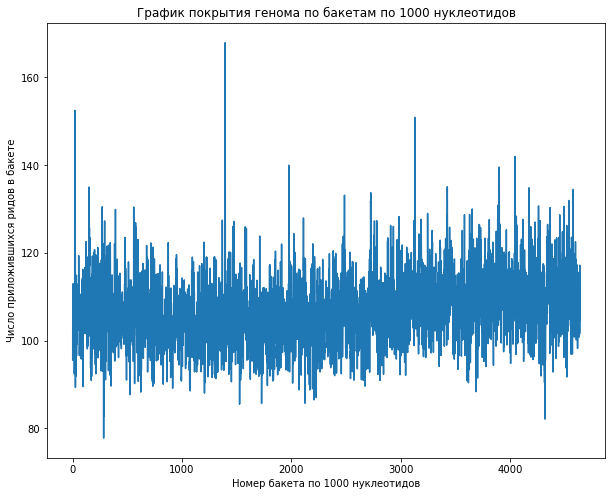

In [41]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()
plt.title("График покрытия генома по бакетам по 1000 нуклеотидов")
ax.set_xlabel("Номер бакета по 1000 нуклеотидов")
ax.set_ylabel("Число приложившихся ридов в бакете")
plt.plot(arr2)
plt.show()

In [42]:
arr2 = []
start = 0
summ = 0
while start + 10000 < len(arr1):
    for i in range(start, start+10000):
        summ += arr1[i]
    start += 10000
    arr2.append(summ/10000)
    summ = 0

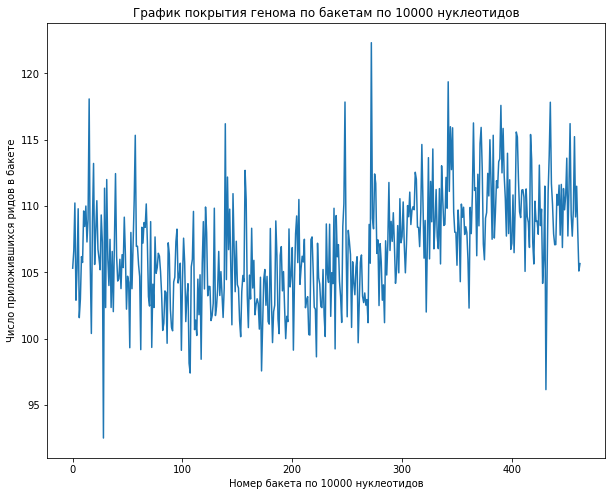

In [43]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()
plt.title("График покрытия генома по бакетам по 10000 нуклеотидов")
ax.set_xlabel("Номер бакета по 10000 нуклеотидов")
ax.set_ylabel("Число приложившихся ридов в бакете")
plt.plot(arr2)
plt.show()

In [44]:
arr2 = []
start = 0
summ = 0
while start + 100000 < len(arr1):
    for i in range(start, start+100000):
        summ += arr1[i]
    start += 100000
    arr2.append(summ/100000)
    summ = 0

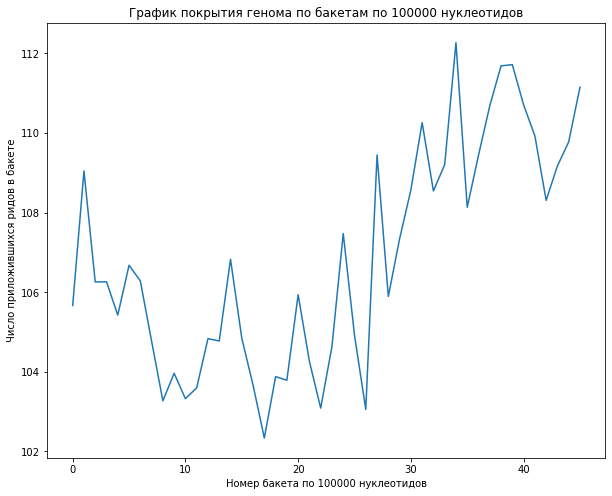

In [45]:
plt.figure(figsize=(10, 8))
ax = plt.subplot()
plt.title("График покрытия генома по бакетам по 100000 нуклеотидов")
ax.set_xlabel("Номер бакета по 100000 нуклеотидов")
ax.set_ylabel("Число приложившихся ридов в бакете")
plt.plot(arr2)
plt.show()

In [77]:
sum = 0
for nuc in arr1:
    sum += nuc
sum /= len(arr1)
print("Среднее покрытие генома:", sum)

Среднее покрытие генома: 106.84518118187158


In [78]:
sum = 0
for nuc in arr1:
    if nuc != 0:
        sum += 1
sum /= len(arr1)
print("Доля покрытой области генома: ", sum*100, "%", sep='')

Доля покрытой области генома: 100.0%


### Задание 2 ###

In [128]:
arr = []
for read in samfile.fetch():
    if read.is_paired:
        if read.template_length > 0 and read.template_length < 1000 and read.pos < read.pnext:
            arr.append(read.template_length)

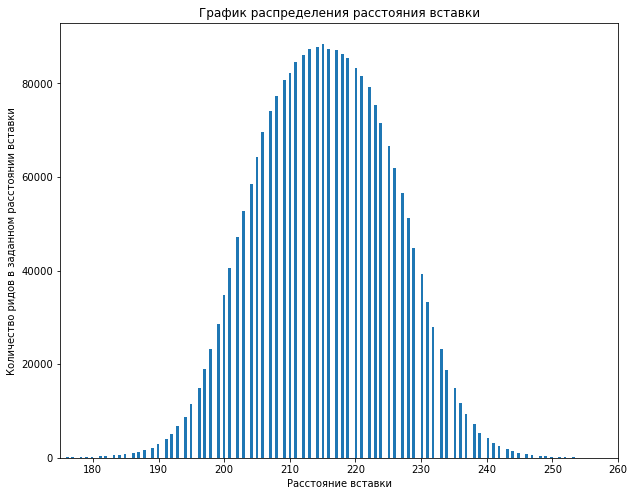

In [134]:
plt.figure(figsize=(10, 8))
plt.hist(arr, bins=1000)
plt.xlim(right=260)
plt.xlim(left=175)
ax = plt.subplot()
plt.title("График распределения расстояния вставки")
ax.set_xlabel("Расстояние вставки")
ax.set_ylabel("Количество ридов в заданном расстоянии вставки")
plt.show()

In [139]:
import numpy as np
arrr = np.array(arr)

In [140]:
print("Среднее расстояние вставки:", arrr.mean())

Среднее расстояние вставки: 215.3779855358232


In [141]:
print("Среднеквадратичное отклонение:", arrr.std())

Среднеквадратичное отклонение: 10.658266743021986


Чтобы найти интервал минимальной ширины для 95%, воспользуемся правилом 3 сигм: https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

Т.е. построим доверительный интервал уровня доверия 0,95.

In [149]:
mu = arrr.mean()
sigma = arrr.std()
left = mu - 2*sigma
right = mu + 2*sigma
print("Интервал минимальной ширины для 95% ридов: ", "(", left, "; ", right, ")", sep='')

Интервал минимальной ширины для 95% ридов: (194.06145204977923; 236.69451902186717)


### Задание 3 ###

In [5]:
from Bio import SeqIO
g = "/home/kolchina/ngs_2_data/Illumina/E.coli/MG1655-K12.fasta"
parse = SeqIO.parse(g, "fasta")
genome = 0
for rec in parse:
    genome = rec.seq # геном в виде строки-последовательности нуклеотидов
    break

In [6]:
A = {'C': 0, 'G': 0, 'T': 0, 'non': 0} # заведем словарики
C = {'A': 0, 'G': 0, 'T': 0, 'non': 0}
G = {'A': 0, 'C': 0, 'T': 0, 'non': 0}
T = {'A': 0, 'C': 0, 'G': 0, 'non': 0}
non = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
arr = []
for read in samfile:
    arr = read.get_aligned_pairs()
    read = read.query_sequence # превращаем рид в строку
    for pair in arr: # перебираем все пары (индекс в риде, индекс в рефе)
        read_ind = pair[0]
        ref_ind = pair[1]
        if read_ind is None: # дальше идет очень красивый и вовсе не костыльный код
            if ref_ind is not None:
                if genome[ref_ind] == 'A':
                    non['A'] += 1
                if genome[ref_ind] == 'C':
                    non['C'] += 1
                if genome[ref_ind] == 'T':
                    non['T'] += 1
                if genome[ref_ind] == 'G':
                    non['G'] += 1
            continue
        if read[read_ind] == 'A':
            if ref_ind is None:
                A['non'] += 1
                continue
            if genome[ref_ind] == 'C':
                A['C'] += 1
            if genome[ref_ind] == 'G':
                A['G'] += 1
            if genome[ref_ind] == 'T':
                A['T'] += 1
        if read[read_ind] == 'C':
            if ref_ind is None:
                C['non'] += 1
                continue
            if genome[ref_ind] == 'G':
                C['G'] += 1
            if genome[ref_ind] == 'T':
                C['T'] += 1
            if genome[ref_ind] == 'A':
                C['A'] += 1
            if genome[ref_ind] is None:
                C['non'] += 1
        if read[read_ind] == 'G':
            if ref_ind is None:
                G['non'] += 1
                continue
            if genome[ref_ind] == 'A':
                G['A'] += 1
            if genome[ref_ind] == 'C':
                G['C'] += 1
            if genome[ref_ind] == 'T':
                G['T'] += 1
            if genome[ref_ind] is None:
                G['non'] += 1
        if read[read_ind] == 'T':
            if ref_ind is None:
                T['non'] += 1
                continue
            if genome[ref_ind] == 'A':
                T['A'] += 1
            if genome[ref_ind] == 'C':
                T['C'] += 1
            if genome[ref_ind] == 'G':
                T['G'] += 1
            if genome[ref_ind] is None:
                T['non'] += 1 # спасибо за внимание

In [7]:
import pandas as pd
# этот сложный код необходим для красивой таблички
data = {'Read \ Reference': ['A', 'C', 'G', 'T', '_'], 'A': ['-', C['A'], G['A'], T['A'], non['A']], 'C': [A['C'], '-', G['C'], T['C'], non['C']], 'G': [A['G'], C['G'], '-', T['G'], non['G']], 'T': [A['T'], C['T'], G['T'], '-', non['T']], '_': [A['non'], C['non'], G['non'], T['non'], '-']}
temp = pd.DataFrame(data, columns = ['Read \ Reference', 'A', 'C', 'G', 'T', '_'])
table = pd.DataFrame(index = ['A', 'C', 'G', 'T', '_'])
st = ''
for i in range(5):
    for j in range(5):
        if i == j:
            continue
        if j == 0:
            st = 'A'
        if j == 1:
            st = 'C'
        if j == 2:
            st = 'G'
        if j == 3:
            st = 'T'
        if j == 4:
            st = 'non'
        s = st
        if s == 'non':
            s = '_'
        if i == 0:
            table.loc['A', s] = A[st]
        if i == 1:
            table.loc['C', s] = C[st]
        if i == 2:
            table.loc['G', s] = G[st]
        if i == 3:
            table.loc['T', s] = T[st]
        if i == 4:
            table.loc['_', s] = non[st]
table.loc['A', 'A'] = '-'
table.loc['C', 'C'] = '-'
table.loc['G', 'G'] = '-'
table.loc['T', 'T'] = '-'
table.loc['_', '_'] = '-'
table = table[['A', 'C', 'G', 'T', '_']]
table

,A,C,G,T,_
A,-,547886.0,356067.0,330422.0,4326.0
C,1103106.0,-,630990.0,752650.0,8949.0
G,757057.0,630877.0,-,1100735.0,8833.0
T,328867.0,350930.0,548661.0,-,4328.0
_,1027.0,848.0,906.0,950.0,-


На этом мучения юного программиста заканчиваются и переходим к финальной части практики:

In [46]:
samfile = pysam.AlignmentFile("real.bam", "r", index_filename="out.index")

Определим средний процент ошибок в ридах:

In [47]:
summ = 0
err = 0
for i in range(5):
    for j in range(5):
        if table.iloc[i,j] != '-':
            summ += int(table.iloc[i,j])
al = 0
for read in samfile:
    read = read.query_sequence
    al += len(read)
err = summ / al
print("Средний процент ошибок в ридах: ", err*100, "%", sep='')

Средний процент ошибок в ридах: 1.493683%


**Вывод**: Получившееся значение логично для Illumina (знаем, что ошибка на ней в районе 1%).